# [5SSD0] Probabilistic Programming - Assignment

Author: Wouter M. Kouw

---

In this assignment, you will apply polynomial regression to predict how much sound an airfoil makes during flight.

In [1]:
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();

  Activating environment at `C:\Users\lange\OneDrive - TU Eindhoven\master\2021-2022\Q2\5SSD0 - Bayesian Machine Learning and Information Processing\prob-programming\pp-final-handin\workspace\Project.toml`


In [2]:
using CSV
using Random
using LinearAlgebra
using DataFrames
using ProgressMeter
using ForneyLab
using Plots
pyplot();

### Problem: Airfoil self-noise

Among other matters, NASA studies how various design factors affect the noise an airfoil makes. In short, the way the wind travels past the foil creates vortices of different shapes. A vortex pushes and pulls the wing which causes it to oscillate and generate sound waves. The figure below shows two designs: a sharp trailing edge (left) and a blunt edge (right). 

<div> 
    <table>
        <tr>
            <td> <img src="figures/Airfoil-schematic-02.png"> </td>
            <td> <img src="figures/Airfoil-schematic-04.png"/> </td>
        </tr>
    </table>
</div>

NASA performed experiments with these airfoils in a windtunnel. They varied several design features, measured oscillation frequency and recorded sound amplitude levels. The results were published as a technical report and the data has been made publicly available ([data set](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)). I have split it into training and test sets for this assignment.

Reference: [Brooks, Pope & Marcolini (1989). Airfoil self-noise and prediction, NASA RP 1218](https://ntrs.nasa.gov/api/citations/19890016302/downloads/19890016302.pdf)

For now, we will only consider regressing the feature "Frequency" onto the feature "Sound amplitude".

In [3]:
# Load training data
trn_data = DataFrame(CSV.File("data/airfoil_trn.csv"))
trn_input = log10.(trn_data[:,1])
trn_output = trn_data[:,6];
N = size(trn_data,1)

# Load test data
tst_data = DataFrame(CSV.File("data/airfoil_tst.csv"));
tst_input = log10.(tst_data[:,1])
tst_output = tst_data[:,6];
M = size(tst_data,1);

Let's visualize this relationship.

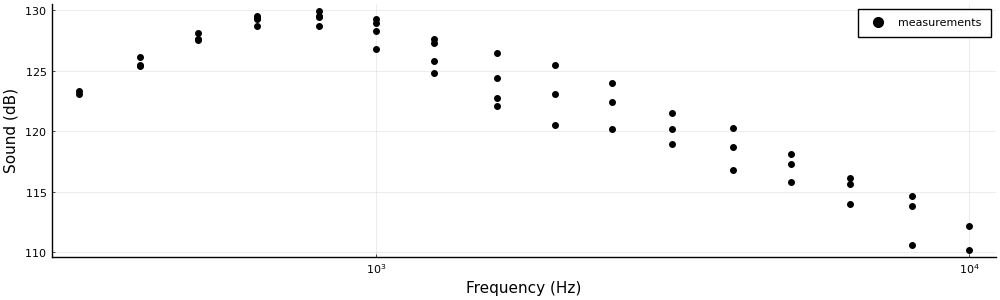

In [4]:
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="measurements")

At first glance, there seems to be a nonlinear relation between these two variables. But it's still relatively smooth, so we don't need a highly flexible function approximator. A polynomial should fit nicely.

### Polynomial regression

We can fit a curve by applying a polynomial basis expansion to the data points. To fit a polynomial of order $d$, we define a basis expansion function $\phi : \mathbb{R} \rightarrow \mathbb{R}^{d+1}$, where 

$$\phi(x) = \begin{bmatrix} 1 & x & x^2 & x^3 & \dots & x^d \end{bmatrix} \, .$$

Our regression model will be:

$$ y_k = \sum_{i=1}^{d+1} \theta_i \phi_i(x_k) + e_k \, ,$$ 

where $\phi_i(x)$ indicates the $i$-th element of the expanded vector. The noise follows a zero-mean Gaussian distribution with precision parameter $\tau$: 

$$e_k \sim \mathcal{N}(0, \tau^{-1}) \, .$$ 

Note that although this model is polynomial in the data, it remains linear in the coefficients. Our goal will be to estimate appropriate coefficients and make accurate predictions for future data points.

A useful step is to precompute the polynomial expansion for all data points:

$$ V = \begin{bmatrix} 1 & x_1 & x_1^2 & \dots x_1^d \\
                       1 & x_2 & x_2^2 & \dots x_2^d \\
                       \vdots & \vdots & \ddots & \vdots \\ 
                       1 & x_N & x_N^2 & \dots x_N^d \end{bmatrix} \quad .$$
                       
This is called a [Vandermonde](https://en.wikipedia.org/wiki/Vandermonde_matrix) matrix. Below is an example of how to make one:

In [5]:
# Order of polynomial
d = 3

# Polynomial basis function
ϕ(x) = [x.^j for j in 0:d]

# Vandermonde matrix
# V = hcat(ϕ(trn_input)...)

ϕ (generic function with 1 method)

## [2pt] Question 1 

- Specify a polynomial regression model of order $d = 3$ using ForneyLab.jl. 
- Define a message passing algorithm.
- Infer a posterior distribution for the coefficients. 

For now, you may fix the precision of the likelihood function as follows: 
- Calculate the variance of the observed signal per distinct frequency level, invert these values and average over them.

In [6]:
# Fixed precision
### YOUR CODE HERE ###
freq_groups = groupby(trn_data, [1]) # group data by frequency
variance = Array{Float64}(undef, length(freq_groups)) 

# calculate variance
for (i, group) in enumerate(freq_groups)
      variance[i] = var(freq_groups[i][:,6]) 
end

τ = mean(inv.(variance))
τ_1 = inv(τ)



0.1915481809846743

In [7]:
# Specify model, define message passing algorithm and infer posteriors
### YOUR CODE HERE ###
V_trn = hcat(ϕ(trn_input)...)

# Start factor graph
graph = FactorGraph();

# Theta prior weight parameters
μ_θ = [100., -80., 800,  -200.]
Σ_θ = Diagonal(10000*ones(d+1))

# Add weight prior to graph
@RV θ ~ GaussianMeanVariance(μ_θ, Σ_θ, id=:f_a)

# Pre-define vectors for storing latent and observed variables
X = Vector{Variable}(undef, N) 
Y = Vector{Variable}(undef, N)

# build our factor graph
for i = 1:N
    # Define i-th covariate
    @RV X[i]
    
    # Define likelihood of i-th response
    @RV Y[i] ~ GaussianMeanVariance(dot(θ,X[i]), τ_1, id=Symbol("f_b"*string(i)))

    # Designate observed variables
    placeholder(X[i], :X, index=i, dims=(4,))
    placeholder(Y[i], :Y, index=i);
    
end

# Load data
data = Dict(:X => [V_trn[i, :] for i = 1:N],
            :Y => trn_output)

# posterior def
posterior = Dict()

# Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ) 
source_code = algorithmSourceCode(algorithm)

# Evaluate the generated code to get the step! function
eval(Meta.parse(source_code));

# Update posterior for θ
step!(data, posterior);

The following cells visualize the regression function using a MAP estimate based on your computed posterior distribution.

In [8]:
# Extract maximum a posteriori (MAP) estimate from posterior
θ_MAP = ForneyLab.unsafeMode(posterior[:θ])

4-element Vector{Float64}:
 -390.0604030042887
  467.7716720700264
 -136.83134324476123
   12.812822189182043

(The `unsafe` function used above is a ForneyLab internal method to deal with potential numerical instabilities.)

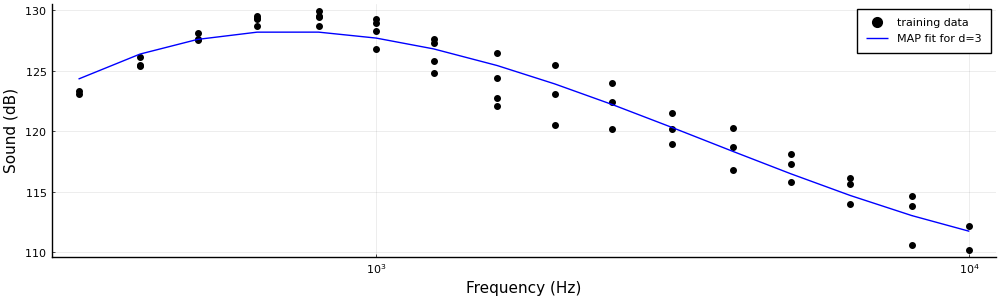

In [9]:
# Generate Vandermonde matrix for training data
V_trn = hcat(ϕ(trn_input)...);

# Sorted index for training inputs (necessary for plotting a line)
sortedix_trn = sortperm(trn_input)

# Visualize fit of current MAP estimate in model
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="training data")
plot!(trn_data[sortedix_trn,1], V_trn[sortedix_trn,:]*θ_MAP, color="blue", label="MAP fit for d=3")

## [1pt] Question 2

- Compute the posterior predictive distribution for each test data point.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the means of the posterior predictive distributions as a solid line.
- Add the prediction uncertainty margin of +/- $\sigma$ around the means (use the `ribbon=` keyword argument for this purpose).

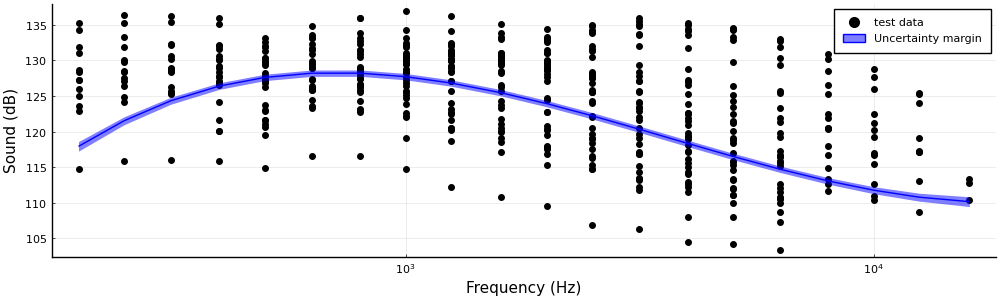

In [10]:
### YOUR CODE HERE ###
V_tst = hcat(ϕ(tst_input)...); 
I_mtx = Matrix{Float64}(I,M,M);

# sorted indices
sortedix_tst = sortperm(tst_input)

μ_pred2 = Array{Float64}(undef, length(tst_input)) 
Σ_pred2 = Array{Float64}(undef, length(tst_input)) 

# take mean and cov matrix from posterior
M_n = ForneyLab.unsafeMean(posterior[:θ])
S_n = ForneyLab.unsafeCov(posterior[:θ])  

# based on formulas in regression lesson
μ_pred2 = V_tst * M_n 
Σ_pred2 = V_tst * S_n * V_tst' + inv(τ) * I_mtx

# sort data for plotting
μ_pred2_sort = μ_pred2[sortedix_tst];
ribbon2 = sqrt.(diag(Σ_pred2)[sortedix_tst])
tst_input_sort = tst_data[sortedix_tst,1];

scatter(tst_data[:,1], tst_output, size=(1000,300), color="black", xscale=:log10, 
        xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="test data")

plot!(tst_input_sort, μ_pred2_sort, color="blue", label="Uncertainty margin", ribbon=ribbon2)


## [1pt] Question 3

- Compute the maximum likelihood (ML) estimate on the training data set.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the predictions based on the ML estimate as a solid line.
- Compute and compare the mean squared errors for both the ML and MAP estimates on the test data. 

θ_MLE = [-499.65873478353024, 570.99047139287, -168.8718036748469, 16.09174064360559]
MSE for MLE = 50.40923695231228
MSE for MAP = 48.876931135037125


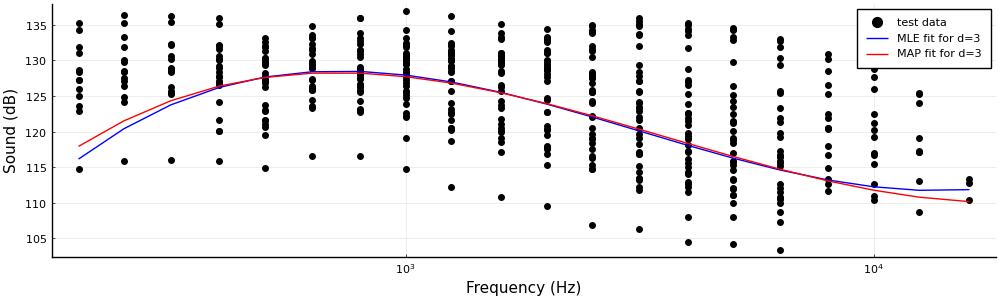

In [11]:
### YOUR CODE HERE ###
# θ_MLE = value for θ that maximizes the likelihood function
# use pseudo-inverse: theta_ML = inv(X'*X)* X'* y 
θ_MLE = inv(V_trn'*V_trn) * (V_trn'*trn_output); 
println("θ_MLE = $(θ_MLE)")

y_pred_mle = V_tst[sortedix_tst,:]*θ_MLE
y_pred_map = V_tst[sortedix_tst,:]*θ_MAP

mse_mle = mean((V_tst * θ_MLE .- tst_output).^2)
println("MSE for MLE = $(mse_mle)")

mse_map = mean((V_tst * θ_MAP .- tst_output).^2)
println("MSE for MAP = $(mse_map)")

# Visualize fit of current MLE/MAP estimate in model
scatter(tst_data[:,1], tst_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="test data")
plot!(tst_data[sortedix_tst,1], y_pred_mle, color="blue", label="MLE fit for d=3")
plot!(tst_data[sortedix_tst,1], y_pred_map, color="red", label="MAP fit for d=3")

## [3pt] Question 4

We will now treat the precision of the likelihood function as an unknown variable (i.e., we will no longer fix it using a separate estimation procedure).

- Specify a probabilistic model of order $d = 3$ where the unknown likelihood precision is given an appropriate prior distribution. 
- Define a message passing procedure to simultaneously estimate coefficients and likelihood precision.
- Infer a posterior distribution for the coefficients and the likelihood precision.

In [12]:
### YOUR CODE HERE ###
V_trn = hcat(ϕ(trn_input)...)

# Start factor graph
graph_q4 = FactorGraph();

# Theta prior weight parameters
μ_θ = [100., -80., 800,  -200.]
Σ_θ = Diagonal(10000*ones(d+1))

@RV θ ~ GaussianMeanVariance(μ_θ, Σ_θ, id=:f_a)

# Add precision prior to graph
a = placeholder(:a) 
b = placeholder(:b) 

@RV τ ~ Gamma(a, b, id=:f_c)

# Pre-define vectors for storing latent and observed variables
X = Vector{Variable}(undef, N) 
Y = Vector{Variable}(undef, N)

# build our factor graph
for i = 1:N #N
    # Define i-th covariate
    @RV X[i]
    
    # Define likelihood of i-th response
    @RV Y[i] ~ GaussianMeanPrecision(dot(θ, X[i]), τ, id=Symbol("f_b"*string(i)))

    # Designate observed variables
    placeholder(X[i], :X, index=i, dims=(d+1,))
    placeholder(Y[i], :Y, index=i);
    
end

# We specify a recognition distribution
q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])

# Define and compile the algorithm
algorithm = messagePassingAlgorithm() 
source_code = algorithmSourceCode(algorithm);

# Bring the generated source code into scope
eval(Meta.parse(source_code));

# Initialize posteriors
posteriors_q4 = Dict()
posteriors_q4[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1, b=2)

# Load data
data_q4 = Dict(:X => [V_trn[i, :] for i = 1:N],
               :Y => trn_output,
               :a => posteriors_q4[:τ].params[:a],
               :b => posteriors_q4[:τ].params[:b]);

# Iterate updates
@showprogress for i = 1:10 #10
    
    # Update classification parameters
    stepθ!(data_q4, posteriors_q4)
    
    # Update local variational parameters
    stepτ!(data_q4, posteriors_q4)    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


θ_MAP = [-390.0604030042887, 467.7716720700264, -136.83134324476123, 12.812822189182043]


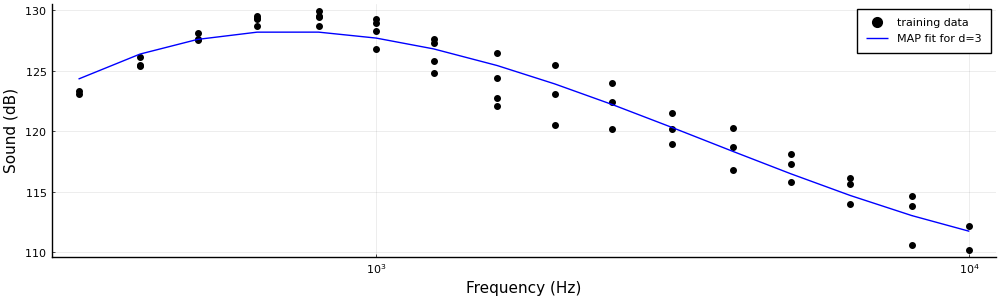

In [13]:
# Extract maximum a posteriori (MAP) estimate from posterior
θ_MAP4 = ForneyLab.unsafeMode(posterior[:θ]);
println("θ_MAP = $(θ_MAP4)")

# Vandermonde matrix
V_trn = hcat(ϕ(trn_input)...)

# Visualize fit of current MAP estimate on training data
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="training data")
plot!(trn_data[sortedix_trn,1], V_trn[sortedix_trn,:]*θ_MAP4, color="blue", label="MAP fit for d=3")

## [1pt] Question 5 

- Compute the posterior predictive distribution for each test data point. 

Note: that would normally require marginalizing over the precision posterior. You may use a simple approximation instead: fix the precision with the MAP estimate based on your computed posterior.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the means of the posterior predictive distributions as a solid line.
- Add the prediction uncertainty margin of +/- $\sigma$ around the means (use the `ribbon=` keyword argument for this purpose).

Hint: if `ForneyLab.unsafeMode()` doesn't work, then you can extract the posterior parameters and compute the mode according to the expressions given in Appendix B of [Bishop's Pattern Recognition & Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

MSE for θ_MAP4 = 48.876931135037125


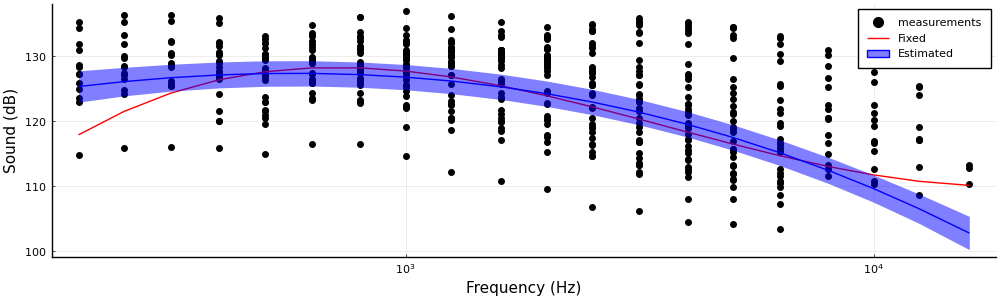

In [14]:
### YOUR CODE HERE ###
V_tst = hcat(ϕ(tst_input)...); 
I_mtx = Matrix{Float64}(I,M,M);

# # get params from posterior distribution
μ_θ = ForneyLab.unsafeMean(posteriors_q4[:θ])
Σ_θ = ForneyLab.unsafeCov(posteriors_q4[:θ])  

# get a and b for τ ~ Gamma(a,b)
a = posteriors_q4[:τ].params[:a];
b = posteriors_q4[:τ].params[:b];

# compute MAP for τ
τ_MAP = (a-1)/b;
# println(τ_MAP)

# print MSE out of curiosity...
mse_map = mean((V_tst * θ_MAP4 .- tst_output).^2)
println("MSE for θ_MAP4 = $(mse_map)")

# based on formulas in regression lesson
μ_pred5 = V_tst * μ_θ;
Σ_pred5 = V_tst * Σ_θ * V_tst' + inv(τ_MAP) * I_mtx;

μ_pred5_sort = μ_pred5[sortedix_tst]

ribbon = sqrt.(diag(Σ_pred5)[sortedix_tst]);

scatter(tst_data[:,1], tst_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="measurements")
plot!(tst_input_sort, μ_pred2_sort, color="red", label="Fixed")
plot!(tst_input_sort, μ_pred5_sort, color="blue", ribbon=ribbon, label="Estimated")




## [2pt] Question 6

- Alter the inference procedure defined for Question 4 such that you also compute Free Energy.
- Define models for polynomials of order $d = 1, \dots, 5$ and store the Free Energy for each model.
- Select the model with the smallest free energy and report the order of the polynomial.

In [15]:
### YOUR CODE HERE ###

# free energy for each model as index in array
F = Float64[]

# loop from d = 1 to d = 5
@showprogress for d = 1:5
    
    # construct d-dimensional dataset
    ϕ(x) = [x.^j for j in 0:d]
    V_q6 = hcat(ϕ(trn_input)...)
    
    # FL factor graph
    graph_q6 = FactorGraph();
    
    # Theta prior weight parameters
    μ_θ = zeros(d+1)
    Σ_θ = Diagonal(1000*ones(d+1))

    @RV θ ~ GaussianMeanVariance(μ_θ, Σ_θ, id=:f_a)

    # Add precision prior to graph
    a = placeholder(:a) 
    b = placeholder(:b) 

    @RV τ ~ Gamma(a, b, id=:f_c)

    # Pre-define vectors for storing latent and observed variables
    X = Vector{Variable}(undef, N) 
    Y = Vector{Variable}(undef, N)

    # build our factor graph
    for i = 1:N #N
        # Define i-th covariate
        @RV X[i]

        # Define likelihood of i-th response
        @RV Y[i] ~ GaussianMeanPrecision(dot(θ, X[i]), τ, id=Symbol("f_b"*string(i)))

        # Designate observed variables
        placeholder(X[i], :X, index=i, dims=(d+1,))
        placeholder(Y[i], :Y, index=i);

    end
    
    # We specify a recognition distribution
    q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])

    # Define and compile the algorithm, include free energy computations
    algorithm = messagePassingAlgorithm(free_energy=true)
    source_code = algorithmSourceCode(algorithm, free_energy=true);

    # Bring the generated source code into scope
    eval(Meta.parse(source_code));    

    # Initialize posteriors
    posteriors_q6 = Dict()
    posteriors_q6[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1, b=2)

    # Load data
    data_q6 = Dict(:X => [V_q6[i, :] for i = 1:N],
                   :Y => trn_output,
                   :a => posteriors_q6[:τ].params[:a],
                   :b => posteriors_q6[:τ].params[:b]);
    F_loc = 0
    
    # Iterate updates
    for i = 1:5 #10

        # Update classification parameters
        stepθ!(data_q6, posteriors_q6)

        # Update local variational parameters
        stepτ!(data_q6, posteriors_q6)   
        
        F_loc = freeEnergy(data_q6, posteriors_q6)
        
        # FE should be going DOWN!!!
        println("FE = $(round(F_loc, digits=3)) for d = $(d) at i = $(i) ")

    end

    push!(F, F_loc)
end

F_min = findmin(F)

# println("MIN Free Energy for each model [1-5] = $(F)")
println("MIN Free Energy = $(F_min[1])")
println("Polynomial order with lowest FE, d = $(F_min[2])")



FE = 147.893 for d = 1 at i = 1 
FE = 147.231 for d = 1 at i = 2 
FE = 147.231 for d = 1 at i = 3 
FE = 147.231 for d = 1 at i = 4 
FE = 147.231 for d = 1 at i = 5 


Progress:  40%|█████████████████                        |  ETA: 0:00:39

FE = 118.474 for d = 2 at i = 1 
FE = 118.341 for d = 2 at i = 2 
FE = 118.34 for d = 2 at i = 3 
FE = 118.34 for d = 2 at i = 4 
FE = 118.34 for d = 2 at i = 5 


Progress:  60%|█████████████████████████                |  ETA: 0:00:26

FE = 122.334 for d = 3 at i = 1 
FE = 122.067 for d = 3 at i = 2 
FE = 122.066 for d = 3 at i = 3 
FE = 122.066 for d = 3 at i = 4 
FE = 122.066 for d = 3 at i = 5 


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:13

FE = 116.273 for d = 4 at i = 1 
FE = 116.253 for d = 4 at i = 2 
FE = 116.253 for d = 4 at i = 3 
FE = 116.253 for d = 4 at i = 4 
FE = 116.253 for d = 4 at i = 5 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


FE = 118.878 for d = 5 at i = 1 
FE = 118.861 for d = 5 at i = 2 
FE = 118.861 for d = 5 at i = 3 
FE = 118.861 for d = 5 at i = 4 
FE = 118.861 for d = 5 at i = 5 
MIN Free Energy = 116.2528285092443
Polynomial order with lowest FE, d = 4


In [17]:
# easter egg #
println(":)")

:)
